## Load datasets

SUMMARY OF CHANGES FROM V1
- XGBoost Hyper-Parameters are tuned using HyperOpt a Bayesian Approach
- Train-Test Split Introduced (Could use CV K-fold to decide optimal split in future) 
- Some ideas: Scaling and Encoding, try different solutions 
- Monotonic Constraints
- Check out ANN for prediction: MLP Regressor

In [1]:
import pandas as pd
import sklearn as sk
import plotly as pl
import matplotlib
import matplotlib.pyplot as plt
import math
import patsy as patsy
import pickle
import statsmodels.api as sm
import numpy as np 
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error
import re
import nltk
#nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stop_words = stopwords.words('English')
import textblob
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
import collections
from textblob import TextBlob, Word


import functions as f ## imports all the functions that are in a separate file to keep this file cleaner

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewtobin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dftrain = pd.read_csv("/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/train.csv",index_col='ad_id')
dftest  = pd.read_csv( "/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/test.csv",index_col='ad_id')

# Q1 Predicting Price

## Data Cleaning and Prep

In [4]:
dftrain = f.prep_data(dftrain) ## prepping the data
## DATA Prep: 
## remove new homes ads, 
## drop county, environment, description, features
## fixes BER exempt problem 
## sets null values to 0
## log transform on price
## splits the facility variable into a dummy matrix (FACILITY DROPPED FOR NOW)

In [5]:
dftrain = f.remove_outliers(dftrain) ## removing any outliers from the data

In [6]:
## cleans the desc_feat text column
dftrain['desc_feat'] = f.clean_text(dftrain['desc_feat'], stop_words)
dftrain['lemmatised']  = dftrain['desc_feat'].apply(f.lemmatize_with_postag)

In [9]:
## creates lists of nouns and adjectives (COULD TAKE A WHILE, LOTS GOING ON)
dftrain = f.nouns_and_adj(dftrain, stop_words)

In [10]:
## word counts for different unstructured variables
dftrain['noun_count'] = dftrain['nouns'].str.split().apply(len).astype('float64')
dftrain['adj_count'] = dftrain['adjectives'].str.split().apply(len).astype('float64')
dftrain['lemma_count'] = dftrain['lemmatised'].str.split().apply(len).astype('float64')

In [11]:
## average word length for different descriptions
dftrain['avg_noun_length']=dftrain['nouns'].apply(f.average_word_length)
dftrain['avg_adj_length']=dftrain['adjectives'].apply(f.average_word_length)
dftrain['avg_lemma_length']=dftrain['lemmatised'].apply(f.average_word_length)

In [12]:
## creates a dummy matrix that is shows if the word is present in an ad
## we can trim down this matrix so that it only includes certain words
noun_dtm = f.count_vectorize(dftrain, 'nouns')
adj_dtm = f.count_vectorize(dftrain, 'adjectives')
lemma_dtm = f.count_vectorize(dftrain, 'lemmatised')

#### splits dataset into the top 25% and bottom 25%

In [13]:
## gets the top and bottom 25% of the data
top, bottom = f.split_data(dftrain)

In [14]:
## getting the top and bottom nouns
top_nouns, bottom_nouns =  f.extract_keywords(top, 'nouns', 1,1), f.extract_keywords(bottom, 'nouns',1,1)
top_adj, bottom_adj = f.extract_keywords(top, 'adjectives',1,1), f.extract_keywords(bottom, 'adjectives',1,1)
top_lemma, bottom_lemma = f.extract_keywords(top, 'lemmatised',2,2), f.extract_keywords(bottom, 'lemmatised',2,2)

In [15]:
## combining top and bottom columns for all word types, removing duplicates 
nouns = list(dict.fromkeys(top_nouns+bottom_nouns))
adj = list(dict.fromkeys(top_adj+bottom_adj))
lemma = list(dict.fromkeys(top_lemma+bottom_lemma))

In [16]:
noun_dummy = noun_dtm[nouns]
adj_dummy = adj_dtm[adj]
lemma_dummy = lemma_dtm[lemma]

In [17]:
print(noun_dummy.shape)
print(adj_dummy.shape)
print(lemma_dummy.shape)

(2434, 69)
(2434, 16)
(2434, 22)


#### split complete

In [18]:
dfnum = dftrain.select_dtypes(include='float64')
print(dfnum.shape)
dfcat = dftrain.drop(['description_block','features','desc_feat','lemmatised','desc_feat_uncleaned','nouns','adjectives'],axis=1).select_dtypes(exclude='float64')
print(dfcat.shape)

(2434, 13)
(2434, 3)


In [19]:
# scales the numerical data and labels the categorical data
#trans = MinMaxScaler() ## data doesn't need to be scaled for decision trees
lbl = LabelEncoder()
dfcat[:] = dfcat.apply(lbl.fit_transform)
#dfcat = dfcat.astype("category")
#dftrain = f.scale_encode(dftrain, trans, lbl)

In [20]:
for i in dfcat.columns:
    dfcat[i]=dfcat[i].astype('category').cat.codes+1

In [21]:
dftrain = pd.concat([dfcat, dfnum, adj_dummy.drop(['shower'], axis=1), noun_dummy, lemma_dummy
], axis = 1)

#### Q2 DFTRAIN PREP

In [19]:
dftrain_q2 = pd.concat([dfcat, dfnum] , axis = 1)

In [20]:
dftrain_q2.to_csv('q2_dftrain.csv')

#### CONTINUE Q1 HERE...

In [19]:
dftrain.head()

,area,ber_classification,property_type,bathrooms,beds,latitude,longitude,price,surface,log_price,...,utility room,walk distance,wash machine,double glaze,entrance hallway,fit kitchen,floor apartment,open plan,shopping centre,time buyer
ad_id,,,,,,,,,,,,,,,,,,,,,
11161103,92,17,3,1.0,1.0,53.353395,-6.458716,600000.0,0.0,13.304685,...,0,0,0,0,0,0,0,0,0,0
11185670,73,14,3,2.0,5.0,53.375467,-6.062246,980000.0,202.0,13.795308,...,0,0,0,0,0,0,0,0,0,0
11421934,24,16,3,2.0,3.0,53.246732,-6.174917,850000.0,150.0,13.652992,...,0,0,0,0,0,0,0,0,0,0
11487466,63,8,1,2.0,3.0,53.403799,-6.294608,230000.0,0.0,12.345835,...,0,0,0,0,0,0,0,1,1,0
11489764,63,10,1,2.0,2.0,53.402663,-6.294619,189950.0,0.0,12.154516,...,0,0,0,0,0,0,0,1,1,0


In [5]:
#dftrain = f.scale(dftrain, trans)

In [22]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)

In [23]:
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 122)
Testing Data Rows and Columns: (487, 122)


In [24]:
## defining the inputs and targets for training and testing
X_train = train.drop(['price', 'log_price'#, 'desc_feat', 'description_block', 'lemmatised', 'features'
], axis=1)
Y_train = train['log_price']

X_test = test.drop(['price', 'log_price'#, 'desc_feat', 'description_block', 'lemmatised', 'features'
], axis=1)
Y_test = test['log_price']

## Train Model

### Tuning Hyperparameters

In [25]:
space={'max_depth': hp.quniform("max_depth", 5, 10, 1),
        #'gamma': hp.uniform ('gamma', 1,9),
        'eta' : hp.uniform('eta', 0.01, 0.5),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 500,
        'seed': 0
    }

In [26]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1947, 120) (1947,) (487, 120) (487,)


In [27]:
## Define a grid of potential values for each hyperparameter
def objective(space):
   reg = xgb.XGBRegressor(n_estimators =space['n_estimators'], 
                           max_depth = int(space['max_depth']), 
                           #gamma = space['gamma'],
                           #reg_alpha = space['reg_alpha'],
                           #reg_lambda = space['reg_lambda'], 
                           eta = space['eta'], 
                           subsample = space['subsample'],
                           min_child_weight = space['min_child_weight'],
                           colsample_bytree=int(space['colsample_bytree']))
   
   model = reg.fit(X_train, Y_train,
                     eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     early_stopping_rounds = 10,
                     verbose = 0)

   pred = reg.predict(X_train)
   #accuracy = accuracy_score(eval_data['log_price'], pred>0.5, normalize=False)
   accuracy = mean_absolute_error(Y_train, pred>0.5)
       
   return {'loss': -accuracy, 'status': STATUS_OK }

In [28]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                        )

100%|██████████| 100/100 [01:42<00:00,  1.03s/trial, best loss: -11.847514734486403]


In [29]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

In [30]:
best_hyperparams

{'colsample_bytree': 0.8116560943350629,
 'eta': 0.49198660671009853,
 'max_depth': 10,
 'min_child_weight': 8,
 'subsample': 0.6391837187428481}

### Final Training Parameters

In [29]:
xg_model = xgb.XGBRegressor(**best_hyperparams)
xg_model=xg_model.fit(X_train,Y_train, eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                early_stopping_rounds = 10, verbose=0)

## Test Model

In [ ]:
#trans.inverse_transform(Y_train)

In [34]:
xg_model = xgb.XGBRegressor(**best_hyperparams)
xg_model=xg_model.fit(X_train, Y_train, eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                early_stopping_rounds = 10, verbose=0)

In [35]:
# predictions for training data (XGBOOST)
f.make_predictions(train, X_train, xg_model)
f.make_predictions(test, X_test, xg_model)

In [49]:
## creates a regular regression model
OLS_reg = LinearRegression().fit(X_train, Y_train)

In [ ]:
# predictions for training data (OLS Regression)
f.make_predictions(train, X_train, OLS_reg)
f.make_predictions(test, X_test, OLS_reg)

In [ ]:
train_OLS1 = np.corrcoef(train['price'], train['predicted_price'])
train_OLS2 = correlation_matrix[0,1]
train_OLS3 = correlation_xy**2 ## R-Squared

In [ ]:
train_OLS1 = np.corrcoef(test['price'], test['predicted_price'])
train_OLS2 = correlation_matrix[0,1]
train_OLS3 = correlation_xy**2 ## R-Squared

In [ ]:
OLS ={
    'Train MdAPE': f.MdAPE(train['price'], train['predicted_price']),
    'Train MAPE': f.MAPE(train['price'], train['predicted_price']),
    'Train R-Squared': train_OLS3,
    'Train MdAPE': f.MdAPE(test['price'], test['predicted_price']),
    'Train MAPE': f.MAPE(test['price'], test['predicted_price']),
    'Train R-Squared': test_OLS3
}

### to compare with V1 OLS Regression run these cells

In [ ]:
## Accuracy Measures for Train and Testing Data (OLS Regression)
print('OLS Training MdAPE: ', f.MdAPE(train['price'], train['predicted_price']), '%')
print('OLS Training MAPE: ', f.MAPE(train['price'], train['predicted_price']), '%')

print('OLS Testing MdAPE: ', f.MdAPE(test['price'], test['predicted_price']), '%')
print('OLS Testing MAPE: ', f.MAPE(test['price'], test['predicted_price']), '%')

### model accuracy metrics

In [46]:
XGB1 = np.corrcoef(train['price'], train['predicted_price'])
XGB2 = XGB1[0,1]
XGB3 = XGB2**2

XGB4 = np.corrcoef(test['price'], test['predicted_price'])
XGB5 = XGB4[0,1]
XGB6 = XGB5**2

In [45]:
XGBoost ={
    'Train MdAPE': f.MdAPE(train['price'], train['predicted_price']),
    'Train MAPE': f.MAPE(train['price'], train['predicted_price']),
    'Train R-Squared': XGB3,
    'Train MdAPE': f.MdAPE(test['price'], test['predicted_price']),
    'Train MAPE': f.MAPE(test['price'], test['predicted_price']),
    'Train R-Squared': XGB6
}

In [47]:
## Accuracy Measures for Train and Testing Data
print('Training')
print('MdAPE:', f.MdAPE(train['price'], train['predicted_price']), '%')
print('MAPE:', f.MAPE(train['price'], train['predicted_price']), '%')
print('R-Squared:', round(r_squared_train, 4))
print('--------------------------------------', '\n')

print('Testing')
print('MdAPE:', f.MdAPE(test['price'], test['predicted_price']), '%')
print('MAPE:', f.MAPE(test['price'], test['predicted_price']), '%')
print('R-Squared:', r_squared_test)

Training
MdAPE: 5.57 %
MAPE: 7.28 %


NameError: name 'r_squared_train' is not defined

In [48]:
f.apply_price_bins(test, train)
f.eval_by_dimension('price_range', test, train)

,price_range,MAPE,MdAPE,# Testing Rows,# Training Rows
0,"(0, 50000]",NaN,NaN,0,0
1,"(50000, 100000]",NaN,NaN,0,1
2,"(100000, 150000]",34.72,34.72,1,11
3,"(150000, 200000]",19.32,15.15,24,110
4,"(200000, 250000]",14.14,11.29,67,239
5,"(250000, 300000]",15.93,11.64,82,298
6,"(300000, 350000]",17.15,14.20,62,268
7,"(350000, 400000]",15.77,11.96,60,235
8,"(400000, 450000]",22.37,18.97,43,143
9,"(450000, 500000]",16.49,13.00,33,164


## Some insights into the XGBoost Model (Feature Importance & Decision Tree)

In [ ]:
## plotting feature importance
fig, ax = plt.subplots(1,1,figsize=(20,20))
xgb.plot_importance(model, max_num_features=50,ax=ax)

In [45]:
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model, num_trees=model.get_booster().best_iteration)

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'400'}

image.render('xgbtree', format = format)

'filename.png'

## Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = RandomForestRegressor()
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,10,1),
         'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         #'n_estimators': 100
}

def objective(space):
    reg = RandomForestRegressor(
                                    max_depth = space['max_depth'],
                                    max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = 100
    )

    model = reg.fit(X_train, Y_train
                     #eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     #early_stopping_rounds = 10,
                     #verbose = 0
                     )

    pred = reg.predict(X_train)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [49]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=100,
            trials=trials
           )

100%|██████████| 100/100 [00:36<00:00,  2.73trial/s, best loss: -11.845829422388007]


In [50]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])

In [51]:
rf_model = RandomForestRegressor(**best_hyperparams)
rf_model=rf_model.fit(X_train, Y_train)#, #eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                #early_stopping_rounds = 10, verbose=0

In [53]:
# predictions for training data 
f.make_predictions(train, X_train, rf_model)
f.make_predictions(test, X_test, rf_model)

In [54]:
RF1 = np.corrcoef(train['price'], train['predicted_price'])
RF2 = RF1[0,1]
RF3 = RF2**2

RF4 = np.corrcoef(test['price'], test['predicted_price'])
RF5 = RF4[0,1]
RF6 = RF5**2

In [55]:
## Accuracy Measures for Train and Testing Data
print('Training')
print('MdAPE:', f.MdAPE(train['price'], train['predicted_price']), '%')
print('MAPE:', f.MAPE(train['price'], train['predicted_price']), '%')
print('R-Squared:', round(r_squared_train, 4))
print('--------------------------------------', '\n')

print('Testing')
print('MdAPE:', f.MdAPE(test['price'], test['predicted_price']), '%')
print('MAPE:', f.MAPE(test['price'], test['predicted_price']), '%')
print('R-Squared:', r_squared_test)

Training
MdAPE: 3.83 %
MAPE: 5.06 %
R-Squared: 0.9727
-------------------------------------- 

Testing
MdAPE: 9.76 %
MAPE: 13.28 %
R-Squared: 0.8139201384601882


In [82]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'].head(50), y=fi_df['feature_names'].head(50), ax=ax)
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

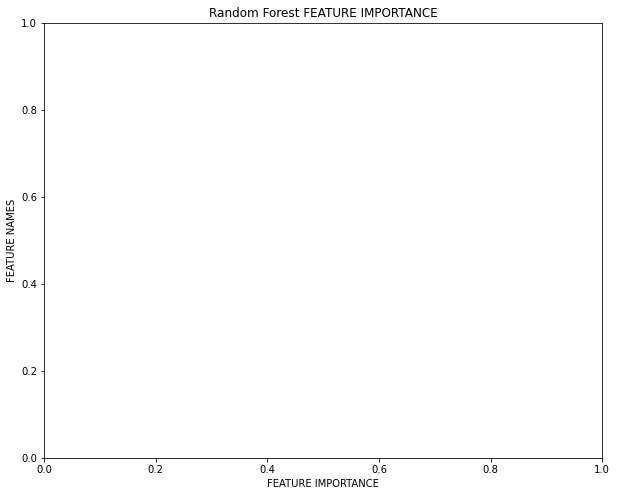

In [83]:
plot_feature_importance(rf_model.feature_importances_, X_train.columns, 'Random Forest ')

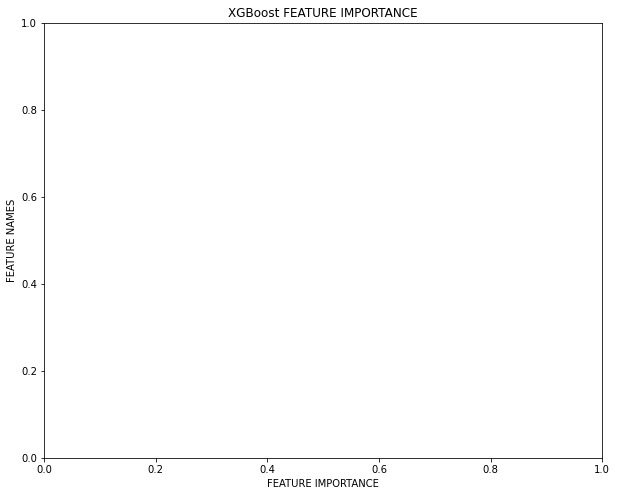

In [84]:
plot_feature_importance(model.feature_importances_, X_train.columns, 'XGBoost ')

In [ ]:
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model, num_trees=model.get_booster().best_iteration)

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'400'}

image.render('xgbtree', format = format)

# Question 2: Predicting Location

#### Number of Classes

In [14]:
dftrain['area'].value_counts()

63     90
115    83
25     73
92     70
135    69
       ..
14      1
39      1
2       1
23      1
46      1
Name: area, Length: 144, dtype: int64

In [15]:
vcounts = dftrain['area'].value_counts().to_frame()
vcounts = vcounts.rename(columns={'area': 'freq'})
print('% Areas with <=10 obs.:',round(len(vcounts[vcounts['freq']<=10])/len(vcounts)*100, 4),'%')
print('% Areas with >25 obs.:',round(len(vcounts[vcounts['freq']>25])/len(vcounts)*100, 4),'%')

% Areas with <=10 obs.: 45.1389 %
% Areas with >25 obs.: 18.75 %


[]

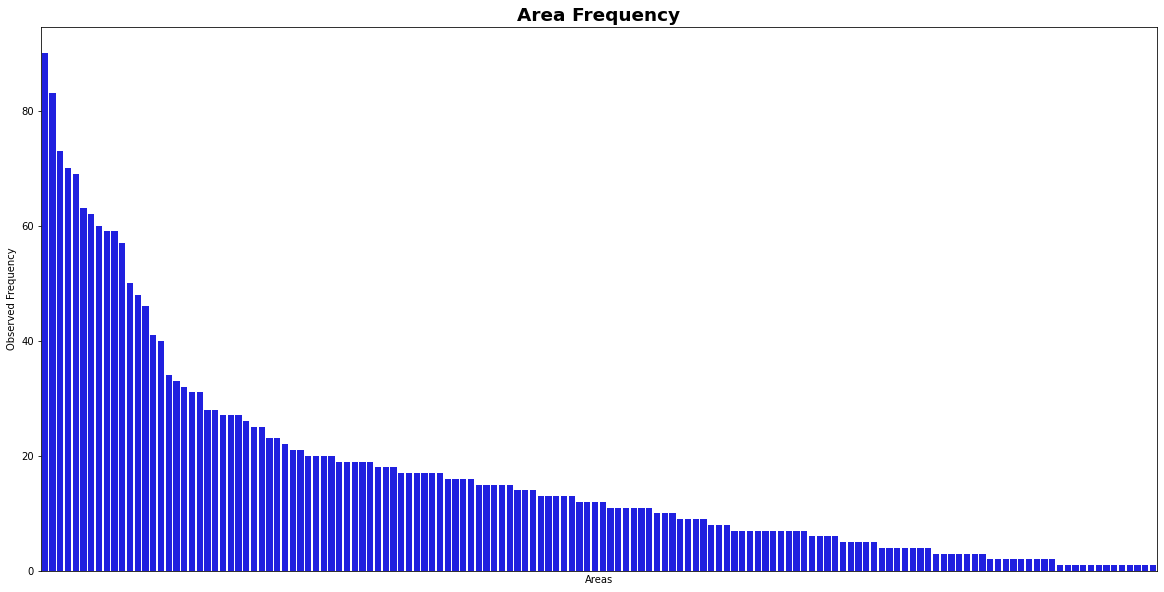

In [16]:
fig, axes = plt.subplots(1, figsize=(20,10), sharey=False)
sns.countplot(data=dftrain, x='area', color='b', order=dftrain['area'].value_counts().index).set(xlabel='Areas', ylabel='Observed Frequency')
axes.set_title('Area Frequency', weight='bold', fontsize=18.5)
axes.xaxis.set_ticks([])


## Prep Data

In [ ]:
# define the model
dftrain = pd.read_csv("q2_dftrain.csv",index_col='ad_id')

In [17]:
dftrain.head()

,area,ber_classification,property_type,bathrooms,beds,latitude,longitude,price,surface,log_price,noun_count,adj_count,lemma_count,avg_noun_length,avg_adj_length,avg_lemma_length
ad_id,,,,,,,,,,,,,,,,
11161103,92,17,3,1.0,1.0,53.353395,-6.458716,600000.0,0.0,13.304685,79.0,2.0,87.0,6.126582,4.000000,6.068966
11185670,73,14,3,2.0,5.0,53.375467,-6.062246,980000.0,202.0,13.795308,98.0,25.0,160.0,5.836735,6.080000,5.900000
11421934,24,16,3,2.0,3.0,53.246732,-6.174917,850000.0,150.0,13.652992,106.0,22.0,161.0,6.566038,7.000000,6.652174
11487466,63,8,1,2.0,3.0,53.403799,-6.294608,230000.0,0.0,12.345835,125.0,29.0,191.0,6.072000,6.103448,5.890052
11489764,63,10,1,2.0,2.0,53.402663,-6.294619,189950.0,0.0,12.154516,97.0,14.0,132.0,5.536082,6.214286,5.606061


In [18]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 16)
Testing Data Rows and Columns: (487, 16)


In [19]:
X_train = train.drop(['area', 'latitude', 'longitude'], axis = 1)
Y_train = train['area']

X_test = test.drop(['area', 'latitude', 'longitude'], axis = 1)
Y_test = test['area']

In [20]:
print('Training Data Rows and Columns:','X',X_train.shape, 'Y',Y_train.shape)
print('Testing Data Rows and Columns:', 'X', X_test.shape, 'Y', Y_test.shape)

Training Data Rows and Columns: X (1947, 13) Y (1947,)
Testing Data Rows and Columns: X (487, 13) Y (487,)


## Multinomial Logistic Regression (4.2% Accuracy)

In [63]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.05)

In [64]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [65]:
# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.042 (0.008)


## Ensemble Methods

### Random Forest (12.6%)

In [104]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [ ]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,10,1),
         'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         'n_estimators': hp.choice('n_estimators',[100])
}

In [ ]:
def objective(space):
    model = RandomForestClassifier( criterion = 'gini',
                                    max_depth = space['max_depth'],
                                    max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = space['n_estimators']
    )
    
    accuracy = cross_val_score(model, X_train,Y_train,cv=10).mean()
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=80,
            trials=trials
           )
best


In [ ]:
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report

In [ ]:
trainedforest = RandomForestClassifier(criterion = 'gini', max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train,Y_train)
predictionforest = trainedforest.predict(X_test)
print(confusion_matrix(Y_test,predictionforest))
print(accuracy_score(Y_test,predictionforest))
print(classification_report(Y_test,predictionforest))
acc5 = accuracy_score(Y_test,predictionforest)

In [ ]:
print(round(acc5*100, 3)

### XGBoost (6.34% Accuracy)

In [ ]:
int(Y_test[Y_test==77].index.values)

In [ ]:
X_test = X_test.drop([int(Y_test[Y_test==77].index.values)],axis=0)

In [ ]:
Y_test = Y_test[Y_test!=77]

In [ ]:
space={'max_depth': hp.quniform("max_depth", 5, 10, 1),
        #'gamma': hp.uniform ('gamma', 1,9),
        'eta' : hp.uniform('eta', 0.01, 0.5),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators',[100,500,1000]),
        'seed': 0
    }

In [ ]:
## Define a grid of potential values for each hyperparameter
def objective(space):
    clg = xgb.XGBClassifier(objective='multi:softmax',
                            booster='gbtree',
                            n_estimators =100, 
                            max_depth = int(space['max_depth']), 
                            #gamma = space['gamma'],
                            #reg_alpha = space['reg_alpha'],
                            #reg_lambda = space['reg_lambda'], 
                            eval_metric='merror',
                            eta = space['eta'], 
                            subsample = space['subsample'],
                            min_child_weight = space['min_child_weight'],
                            colsample_bytree=int(space['colsample_bytree']),
                            num_class = 143)
   
    model =  clg.fit(X_train, Y_train,
                     eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     early_stopping_rounds = 10,
                     verbose = 0)

    pred = clg.predict(X_train)
    #accuracy = accuracy_score(eval_data['log_price'], pred>0.5, normalize=False)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
       
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                        )

In [ ]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'

In [ ]:
model = xgb.XGBClassifier(**best_hyperparams)
model=model.fit(X_train,Y_train, eval_metric='merror',eval_set = [(X_test, Y_test)],
                                 early_stopping_rounds = 10,
                                 verbose=0)

In [ ]:
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report
Y_pred = model.predict(X_test)
#print(confusion_matrix(Y_test,Y_pred))
#print(accuracy_score(Y_test,Y_pred))
#print(classification_report(Y_test,Y_pred))
acc5 = accuracy_score(Y_test,Y_pred)
print(round(acc5*100, 3), '% Accuracy')

## Clustering Approaches

### Heirarchical

In [33]:
loc = dftrain[['latitude', 'longitude']]

In [26]:
from sklearn.preprocessing import normalize
data_scaled = normalize(loc)
data_scaled = pd.DataFrame(data_scaled, columns=loc.columns)
data_scaled.index = dftrain.index
data_scaled.head()

,latitude,longitude
ad_id,,
11161103,0.992752,-0.120178
11185670,0.993612,-0.112852
11421934,0.993343,-0.115196
11487466,0.993125,-0.117058
11489764,0.993125,-0.117060


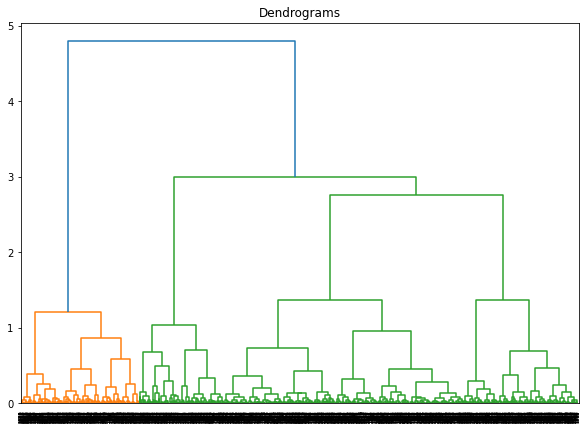

In [40]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(loc, method='ward'))

In [82]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=, affinity='euclidean', linkage='ward')  
cluster.fit_predict(loc)

array([0, 2, 3, ..., 5, 3, 5])

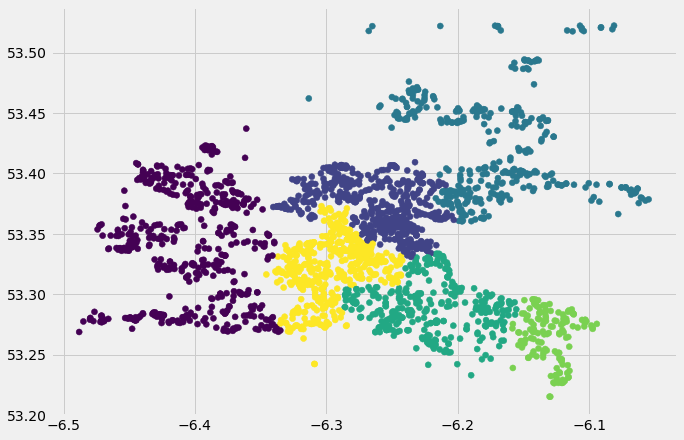

In [83]:
plt.figure(figsize=(10, 7))  
plt.scatter(dftrain['longitude'], dftrain['latitude'], c=cluster.labels_) 

### KMeans

In [21]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [24]:
loc = dftrain[['longitude', 'latitude']]

kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 42,
        }

        # A list holds the SSE values for each k
sse = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    clusters = kmeans.fit(loc).labels_
    column = str(k)+'_clusters'
    dftrain[column] = clusters

#### plotting clusters

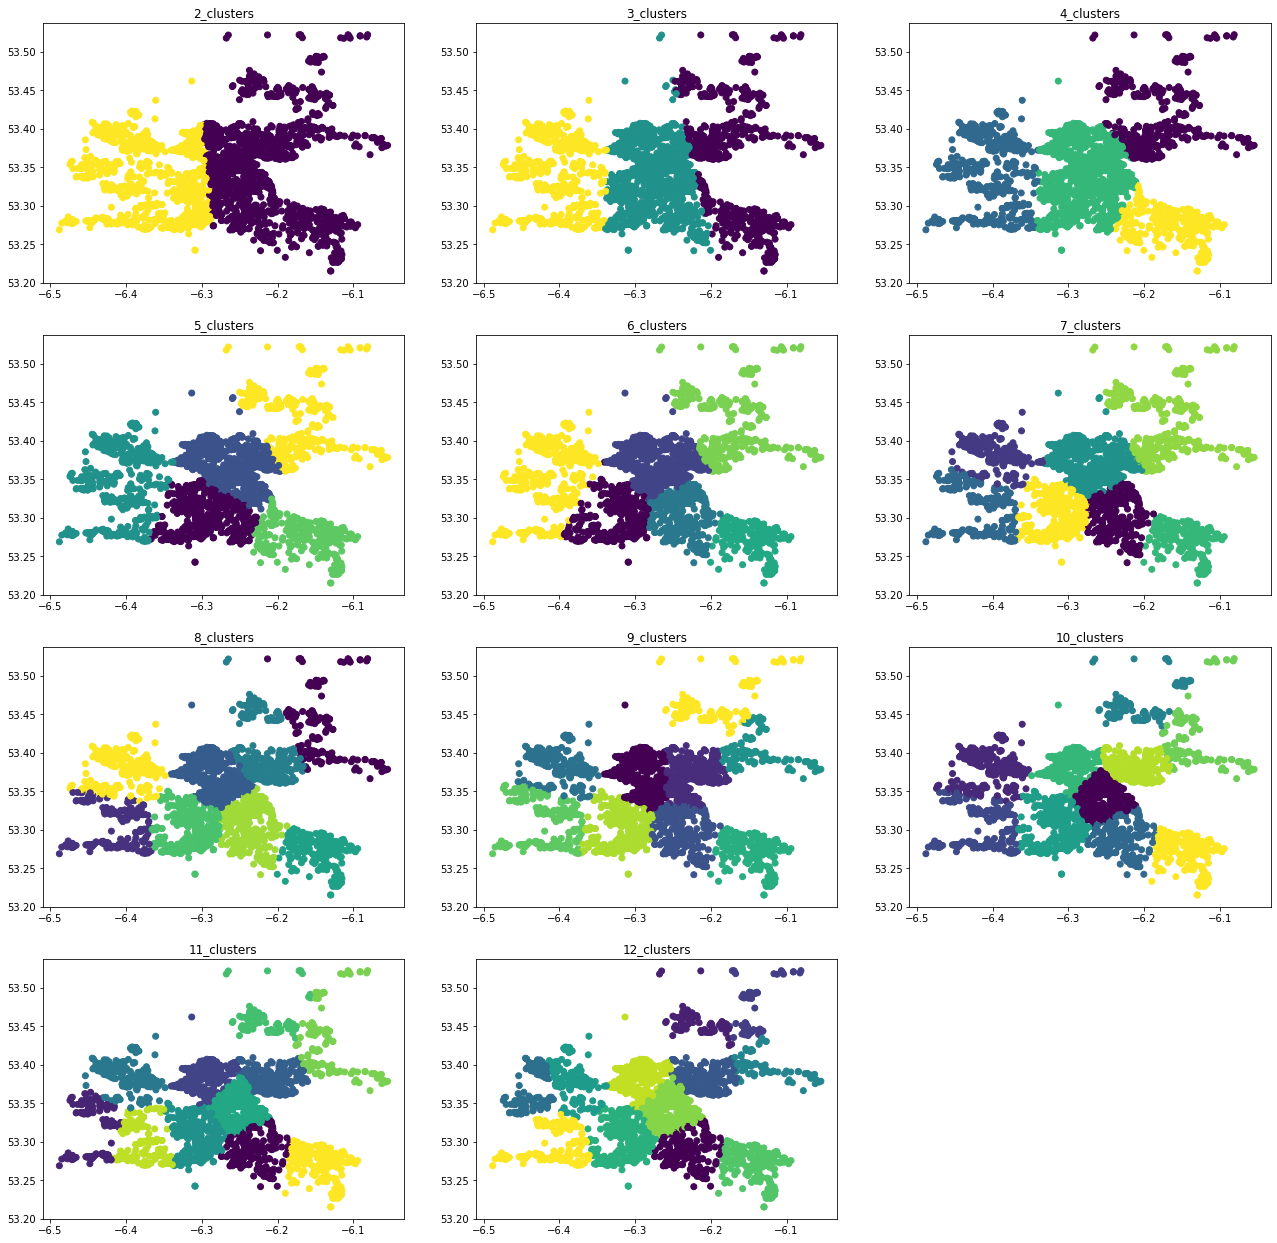

In [26]:
## plotting each variables relationship with Price Variable
plt.figure(figsize=(22,22))
columns = list(dftrain.columns[16:].values)
for i, column in enumerate(columns, 1):
    plt.subplot(4,3,i)
    plt.title(label=column)
    plt.scatter(dftrain['longitude'], dftrain['latitude'], c=dftrain[column]) 
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)

##### Training data prep

In [67]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 27)
Testing Data Rows and Columns: (487, 27)


##### Multi-nomial Logistic Regression

In [35]:
from numpy import mean

In [70]:
#### Granularity vs Predictive Accuracy
def gran_vs_acc(dftrain, train, test):
    results = []
    cluster_cols = list(dftrain.columns[16:].values)
    drop_columns = ['area', 'latitude', 'longitude']+cluster_cols

    X_train = train.drop(drop_columns, axis = 1)
    X_test = test.drop(drop_columns, axis = 1)
    
    for col in cluster_cols:
        Y_train = train[col] 
        Y_test = test[col]

        model = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty = 'l2', C=0.5)

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluate the model and collect the scores
        n_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1)
        results.append([col,
                        (mean(n_scores))])
    
    results = pd.DataFrame(results, columns=['n_clusters', 'accuracy'])
    return results

In [71]:
results = gran_vs_acc(dftrain, train, test)

In [72]:
results.to_csv('mlogreg_nclust_results.csv')

In [73]:
results

,n_clusters,accuracy
0,2_clusters,0.746641
1,3_clusters,0.603061
2,4_clusters,0.557157
3,5_clusters,0.413492
4,6_clusters,0.406009
5,7_clusters,0.350567
6,8_clusters,0.329989
7,9_clusters,0.301162
8,10_clusters,0.296429
9,11_clusters,0.272307


##### SELECT N_CLUSTERS FOR RF AND XGB

In [74]:
## CHOOSE N HERE
n = 2
n_clusters = str(n)+'_clusters'

In [75]:
cluster_cols = list(dftrain.columns[16:].values)
drop_columns = ['area', 'latitude', 'longitude']+cluster_cols

In [76]:
X_train = train.drop(drop_columns, axis = 1)
Y_train = train[n_clusters] ## set this to n_clusters

X_test = test.drop(drop_columns, axis = 1)
Y_test = test[n_clusters] ## set this to n_clusters

##### Random Forest

In [77]:
# define the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [78]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,10,1),
         'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         'n_estimators': hp.choice('n_estimators',[100])
}

In [79]:
def objective(space):
    model = RandomForestClassifier( criterion = 'gini',
                                    max_depth = space['max_depth'],
                                    max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = space['n_estimators']
    )
    
    accuracy = cross_val_score(model, X_train,Y_train,cv=10).mean()
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [80]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=80,
            trials=trials
           )
best

100%|██████████| 80/80 [05:04<00:00,  3.80s/trial, best loss: -0.7447422680412371]


{'max_depth': 6.0,
 'max_features': 3,
 'min_samples_leaf': 0.0050121701934412455,
 'min_samples_split': 0.061702767197756525,
 'n_estimators': 0}

In [81]:
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}

In [82]:
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report
trainedforest = RandomForestClassifier(criterion = 'gini', max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train,Y_train)
predictionforest = trainedforest.predict(X_test)
#print(confusion_matrix(Y_test,predictionforest))
#print(accuracy_score(Y_test,predictionforest))
#print(classification_report(Y_test,predictionforest))
acc5 = accuracy_score(Y_test,predictionforest)
print(round(acc5*100, 3), '% Accuracy')

72.485 % Accuracy


##### XGBoost

In [83]:
space={'max_depth': hp.quniform("max_depth", 5, 10, 1),
        #'gamma': hp.uniform ('gamma', 1,9),
        'eta' : hp.uniform('eta', 0.01, 0.5),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators',[100,500,1000]),
        'seed': 0
    }

In [91]:
## Define a grid of potential values for each hyperparameter
def objective(space):
    clg = xgb.XGBClassifier(objective='multi:softmax',
                            booster='gbtree',
                            n_estimators =100, 
                            max_depth = int(space['max_depth']), 
                            #gamma = space['gamma'],
                            #reg_alpha = space['reg_alpha'],
                            #reg_lambda = space['reg_lambda'], 
                            eval_metric='merror',
                            eta = space['eta'], 
                            subsample = space['subsample'],
                            min_child_weight = space['min_child_weight'],
                            colsample_bytree=int(space['colsample_bytree']),
                            num_class = n+1)
   
    model =  clg.fit(X_train, Y_train,
                     eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     early_stopping_rounds = 10,
                     verbose = 0)

    pred = clg.predict(X_train)
    #accuracy = accuracy_score(eval_data['log_price'], pred>0.5, normalize=False)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
       
    return {'loss': -accuracy, 'status': STATUS_OK }

In [92]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                        )

100%|██████████| 100/100 [00:17<00:00,  5.68trial/s, best loss: -0.35130970724191063]


In [93]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

In [94]:
model = xgb.XGBClassifier(**best_hyperparams)
model=model.fit(X_train,Y_train, eval_metric='merror',eval_set = [(X_test, Y_test)],
                                 early_stopping_rounds = 10,
                                 verbose=0)

In [95]:
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report
Y_pred = model.predict(X_test)
#print(confusion_matrix(Y_test,Y_pred))
#print(accuracy_score(Y_test,Y_pred))
#print(classification_report(Y_test,Y_pred))
acc5 = accuracy_score(Y_test,Y_pred)
print(round(acc5*100, 3), '% Accuracy')

64.682 % Accuracy


## ANNs

In [415]:
from keras.models import Model
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow import keras
from keras import layers
from numpy import array
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

In [417]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [338]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 16)
Testing Data Rows and Columns: (487, 16)


In [339]:
X_train = train.drop(['area', 'latitude', 'longitude'], axis = 1).to_numpy()
Y_train = train[['latitude', 'longitude']].to_numpy()

X_test = test.drop(['area', 'latitude', 'longitude'], axis = 1).to_numpy()
Y_test = test[['latitude', 'longitude']].to_numpy()

In [429]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(2))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [430]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)

In [397]:
def build_regressor(hp):
    model = Sequential(
        [
            layers.Dense(units=hp.Int("units", 32, 128, 32), input_dim=13, activation="relu"),
            layers.Dense(units=2),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        # Objective is one of the metrics.
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model

In [403]:
tuner = kt.RandomSearch(
    hypermodel=build_regressor,
    # The objective name and direction.
    # Name is the f"val_{snake_case_metric_class_name}".
    objective=kt.Objective("val_mean_absolute_error", direction="min"),
    max_trials=3,
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [405]:
tuner.search(
    x=X_train,
    y=Y_train,
    validation_data=(X_test, Y_test)
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
model.fit(X_train, Y_train, epochs=100, batch_size=12, verbose=0)

y1 MAE:72.7840
y2 MAE:200.6047


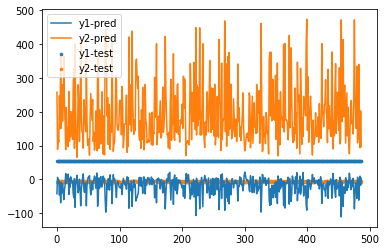

In [394]:
ypred = model.predict(X_test)
print("y1 MAE:%.4f" % mean_absolute_error(Y_test[:,0], ypred[:,0]))
print("y2 MAE:%.4f" % mean_absolute_error(Y_test[:,1], ypred[:,1]))

x_ax = range(len(X_test))
plt.scatter(x_ax, Y_test[:,0],  s=6, label="y1-test")
plt.plot(x_ax, ypred[:,0], label="y1-pred")
plt.scatter(x_ax, Y_test[:,1],  s=6, label="y2-test")
plt.plot(x_ax, ypred[:,1], label="y2-pred")
plt.legend()
plt.show()

## MultiOutputRegressor vs RandomForest Multi-Output

In [323]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = RandomForestRegressor()

In [329]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,30,5),
         #'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         #'n_estimators': 100
}

In [332]:
def objective(space):
    reg = RandomForestRegressor(
                                    max_depth = space['max_depth'],
                                    #max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = 100
    )

    model = reg.fit(X_train, Y_train
                     #eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     #early_stopping_rounds = 10,
                     #verbose = 0
                     )

    pred = reg.predict(X_train)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [333]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=80,
            trials=trials
           )

100%|██████████| 80/80 [00:18<00:00,  4.42trial/s, best loss: -29.307448418641762]


In [334]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])

In [335]:
model = RandomForestRegressor(**best_hyperparams)
model=model.fit(X_train, Y_train)
#eval_metric='rmse',eval_set = [(X_test, Y_test)],
#       early_stopping_rounds = 10, verbose=0
#, #eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                #
                                

In [ ]:
model.predict(X_test)